In [1]:
import torch
torch.cuda.empty_cache()
torch.manual_seed(0)

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2 import HighResDV2
from hr_dv2.high_res import torch_pca

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from featup.util import norm, unnorm
use_norm = True

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_img(path: str, size: int=224) -> tuple[torch.Tensor, np.ndarray]:
    _img = Image.open(path)
    _h, _w = _img.height, _img.width
    t = tr.get_input_transform(size, size)

    img_tensor, img = tr.load_image(path, t)
    img_arr = np.array(img)

    img_tensor.to(torch.float16)
    return img_tensor, img_arr

def set_transforms(net: torch.nn.Module, d: int=3):
    shift_dists = [i for i in range(1, d + 1)]
    fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
    fwd_flip, inv_flip = tr.get_flip_transforms()
    fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
    net.set_transforms(fwd_shift, inv_shift)


In [3]:
IMG_SIZE = 384
out = []
models = ["dino_vits8", "dinov2_vits14_reg"]
fname = f"fig_data/3.jpg"
strides = [0, 1, 2, 3, 4, 8]

for model in models:
    for i in strides:
        print(f"{i}: {model}")
        torch.cuda.empty_cache()
        net = HighResDV2(model, 4, pca_dim=128, dtype=torch.float16)
        net.interpolation_mode = 'nearest-exact'
        net.cuda()
        net.eval()

        set_transforms(net, i)

        size = 322
        img_tensor, img_arr = load_img(fname, size)
        img_tensor = img_tensor.cuda()

        feats_attn_tensor = net.forward(img_tensor, attn_choice='none')
        pcaed = torch_pca(feats_attn_tensor.squeeze(0), 3, max_samples=80000)
        pcaed = tr.to_numpy(pcaed)
        rescaled = rescale_pca(pcaed)
        out.append(rescaled)

0: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


1: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


2: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


3: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


8: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


0: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


1: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


2: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


3: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


4: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


8: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [7]:
def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]
    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_axis_off()
    axin.imshow(inset_data)
    ax.indicate_inset_zoom(axin, edgecolor="r", lw=2)
    axin.set_ylim((y0 + h, y0))
    return axin

0 ['DINO-S-8', 'DINOv2-S-14']
1 ['DINO-S-8', 'DINOv2-S-14']
2 ['DINO-S-8', 'DINOv2-S-14']
3 ['DINO-S-8', 'DINOv2-S-14']
4 ['DINO-S-8', 'DINOv2-S-14']
5 ['DINO-S-8', 'DINOv2-S-14']


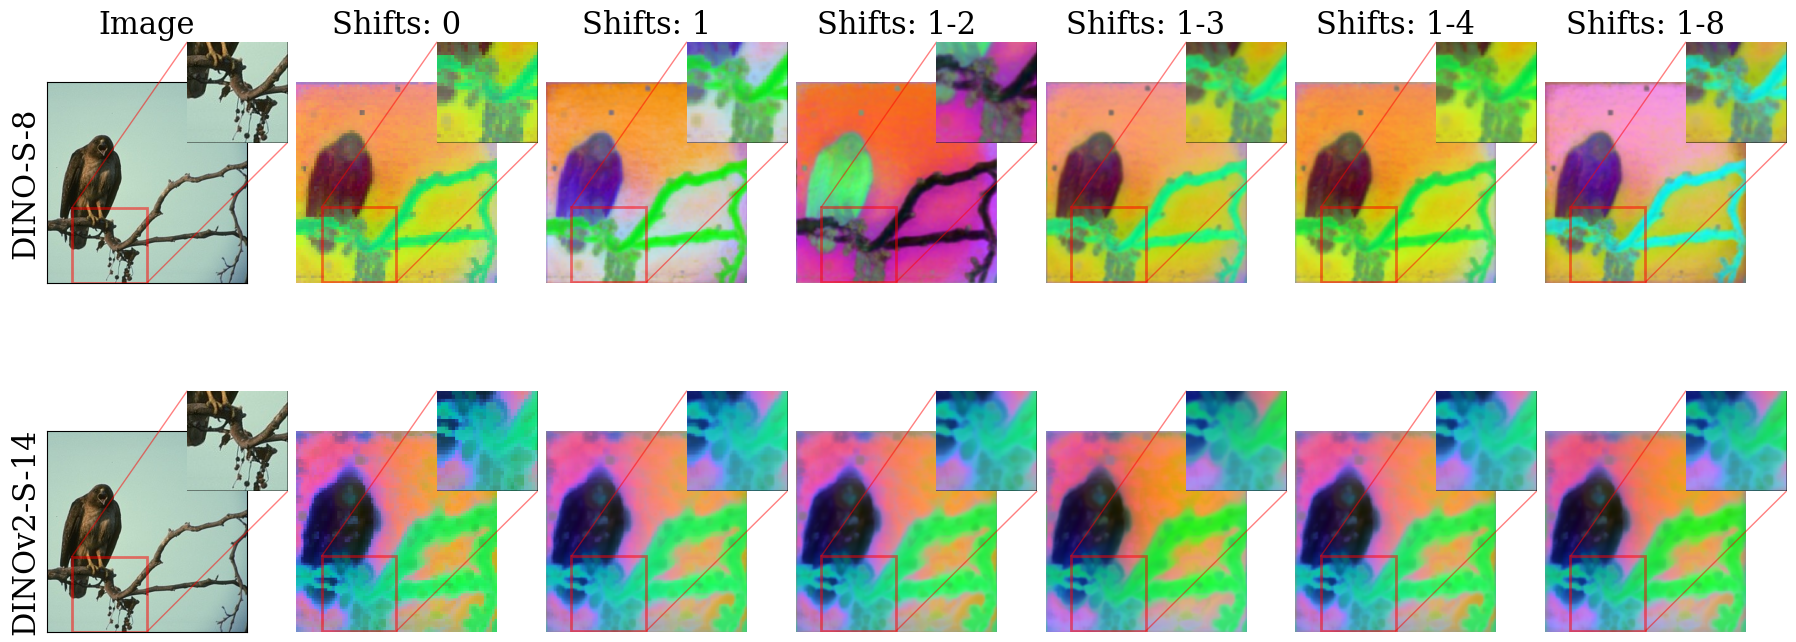

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=len(strides) + 1)
plt.rcParams["font.family"] = "serif"

model_names = ["DINO-S-8", "DINOv2-S-14"]

fig.set_size_inches(18, 8)
i = 0
font_size = 22
for row in range(len(model_names)):
    img = Image.open(f"fig_data/3.jpg")
    axs[row, 0].imshow(img)
    if row == 0:
        axs[row, 0].set_title("Image", fontsize=font_size)
    axs[row, 0].set_ylabel(model_names[row], size=font_size)
    axs[row, 0].set_xticks([])
    axs[row, 0].set_yticks([])

    add_inset_zoom([40, 200, 120, 120], [0.7, 0.7, 0.5, 0.5], np.array(img), axs[row, 0])

    for column, s in enumerate(strides):
        ax = axs[row, column + 1]
        if row == 0:
            print(column, model_names )
            stride_txt = f"{s}" if s < 2 else f"1-{s}"
            ax.set_title(f"Shifts: {stride_txt}", fontsize=font_size)

        model = models[row]
        size = 322 # if model != "dinov2_vits14_reg" else 378

        data = out[i]
        img = data.reshape((size, size, 3))
        ax.imshow(img)
        ax.set_axis_off()

        add_inset_zoom([40, 200, 120, 120], [0.7, 0.7, 0.5, 0.5], img, ax)

        i += 1
plt.tight_layout()
plt.savefig('fig_out/stride_comparison.png')